In [22]:
################i tested rbm from the guy in github, this code has implemented the exact pper from hinton.

import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
from tqdm import tqdm
import h5py
I=0
def _parse_function(example_proto):
    features = {"X": tf.FixedLenFeature((257), tf.float32),
              "Y": tf.FixedLenFeature((257), tf.float32)}
    parsed_features = tf.parse_single_example(example_proto, features)
    return parsed_features["X"], parsed_features["Y"]

def rbm_layer(n_visible, n_hidden, num_epochs, num_cases, lr, ws, bs, layer_n, len_data, directories):
    
    Data_path = directories[0]
    tfrecord_folder_parent = directories[1]
    tfrecord_folder = directories[2]
    
    tfrecord_path_x = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
    sorted_names_x = natsorted(os.listdir(tfrecord_path_x))
    trainfilenames_x = []
    for i in sorted_names_x:
        trainfilenames_x.append(os.path.normpath(os.path.join(tfrecord_path_x,i)))
    filenames_x = tf.placeholder(tf.string, shape=[None])
    dataset_x = tf.data.TFRecordDataset(filenames_x)
    dataset_x = dataset_x.map(_parse_function)  # Parse the record into tensors.
    dataset_x = dataset_x.repeat()  # Repeat the input indefinitely.
    dataset_x = dataset_x.batch(batch_size)
    iterator_x = dataset_x.make_initializable_iterator()

    x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
    W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
    bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
    bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer

    def sample(probs):
        #Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
        return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))


    def gibbs_sample(k):
        #Runs a k-step gibbs chain to sample from the probability distribution of the RBM defined by W, bh, bv
        def gibbs_step(count, k, xk):
            #Runs a single gibbs step. The visible values are initialized to xk
            hk = sample(tf.sigmoid(tf.matmul(xk, W) + bh)) #Propagate the visible values to sample the hidden values
#             xk   = tf.sigmoid(tf.matmul(hk, tf.transpose(W)) + bv)
            xk = sample(tf.truncated_normal((1,n_visible),tf.matmul(hk, tf.transpose(W)) + bv,1))
            return count+1, k, xk
        print('2')
        ct = tf.constant(0) #counter
        #Run gibbs steps for k iterations
        [_, _, x_sample]=control_flow_ops.while_loop(lambda count, num_iter, *args: count < num_iter,
                                             gibbs_step, [ct, tf.constant(k), x], back_prop = False)
        print('3')
        #This is not strictly necessary in this implementation, but if you want to adapt this code to use one of TensorFlow's
        #optimizers, you need this in order to stop tensorflow from propagating gradients back through the gibbs step
        x_sample = tf.stop_gradient(x_sample) 
        print('4')
        return x_sample

    ### Training Update Code
    # Now we implement the contrastive divergence algorithm. First, we get the samples of x and h from the probability distribution
    #The sample of x
    print('1')
    x_sample = gibbs_sample(1) 
    #The sample of the hidden nodes, starting from the visible state of x
    h = sample(tf.sigmoid(tf.matmul(x, W) + bh)) 
    #The sample of the hidden nodes, starting from the visible state of x_sample
    h_sample = sample(tf.sigmoid(tf.matmul(x_sample, W) + bh)) 

    #Next, we update the values of W, bh, and bv, based on the difference between the samples that we drew and the original values
#     size_bt = tf.cast(tf.shape(x)[0], tf.float32)
    W_adder  = tf.multiply(lr, tf.subtract(tf.matmul(tf.transpose(x), h), tf.matmul(tf.transpose(x_sample), h_sample)))
    bv_adder = tf.multiply(lr, tf.reduce_sum(tf.subtract(x, x_sample), 0, True))
    bh_adder = tf.multiply(lr, tf.reduce_sum(tf.subtract(h, h_sample), 0, True))
    #When we do sess.run(updt), TensorFlow will run all 3 update steps
    updt = [W.assign_add(W_adder), bv.assign_add(bv_adder), bh.assign_add(bh_adder)]



    ### Run the graph!
    # Now it's time to start a session and run the graph! 

    with tf.Session() as sess:
        #First, we train the model
        #initialize the variables of the model
        sess.run(tf.global_variables_initializer())
        sess.run(iterator_x.initializer, feed_dict={filenames_x: trainfilenames_x})
#         print(iterator_x.get_next()[0])
        #Run through all of the training data num_epochs times
        for epoch in tqdm(range(num_epochs)):
            #Train the RBM on batch_size examples at a time
#             for X_batch in da(batch_size, layer_n, ws, bs, len_data, name, data_name):
            Data = sess.run(iterator_x.get_next()[0])
            for j in range(layer_n):
#                 print(ws[j].shape)
#                 print(bs[j].shape)
#                 print(type(Data))
                Data = np.matmul(Data,ws[j])+bs[j]
            feed_dict = {x: Data}
            var1 = sess.run(updt, feed_dict)
#             print(bh.eval())
    return var1




In [23]:
# import libraries.
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from pystoi.stoi import stoi
import h5py
######################
#import libraries.
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
####import sounddevice as sd
import time
print('imported')
# #######################
Data_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff'
# Data_path = os.getcwd()
tfrecord_folder_parent = 'tfrecord_files'
tfrecord_folder = 'mixed_10h_norm2'
tfrecord_val_folder = 'validation_10h'
ckpt_folder = '3'
dirs = [Data_path, tfrecord_folder_parent, tfrecord_folder]
 
# len_data = (684108, 257)
len_data = (100000, 257)
val_len = (97278,257)
w=1
#######################
#define reconstruct function to reconstruct sound from framed signal.
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=200, win_length=500, window='hann')
    return recon
#######################
I=0
global batch_size
batch_size = 128
# epochs_num=50
global datalen
datalen=len_data[0]

h = [512,512]
seed = 7
rate1 = 0.1
rate2 = 0.2
from tensorflow.keras.layers import Activation
# from keras.layers import Activation
np.random.seed(seed)
model = Sequential()
act1 = layers.LeakyReLU(alpha=0.1)
model.add(layers.Dropout(rate1, noise_shape=None, seed=None))
# ,kernel_regularizer=regularizers.l2(0.001)
model.add(Dense(h[0], input_dim = w*len_data[1]))
model.add(BatchNormalization())
model.add(act1)
# model.add(Activation('sigmoid'))
act2=layers.LeakyReLU(alpha=0.1)
model.add(layers.Dropout(rate2, noise_shape=None, seed=None))
model.add(Dense(h[1]))
model.add(act2)
# act3=layers.LeakyReLU(alpha=0.1)
# # model.add(layers.Dropout(rate, noise_shape=None, seed=None))
# model.add(Dense(h[2]))
# model.add(act3)
act=layers.LeakyReLU(alpha=0.01)
model.add(Dense(len_data[1]))
#############################################
import os
from natsort import natsorted

# def _parse_function(example_proto):
#     print('1')
#     features = {"X": tf.FixedLenFeature((3*257), tf.float32),
#               "Y": tf.FixedLenFeature((257), tf.float32)}
#     parsed_features = tf.parse_single_example(example_proto, features)
#     print("i was here")
#     print('2')
#     return parsed_features["X"], parsed_features["Y"]

# tfrecord_path = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
# sorted_names = natsorted(os.listdir(tfrecord_path))
# trainfilenames = []
# for i in sorted_names:
#     trainfilenames.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# filenames = tf.placeholder(tf.string, shape=[None])
# dataset = tf.data.TFRecordDataset(filenames)
# dataset = dataset.map(_parse_function)  # Parse the record into tensors.
# dataset = dataset.repeat()  # Repeat the input indefinitely.
# dataset = dataset.batch(batch_size)
# iterator = dataset.make_initializable_iterator()

# # orig_path = os.getcwd()
# tfrecord_path_x = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
# sorted_names_x = natsorted(os.listdir(tfrecord_path_x))
# trainfilenames_x = []
# for i in sorted_names_x:
#     trainfilenames_x.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# filenames_x = tf.placeholder(tf.string, shape=[None])
# dataset_x = tf.data.TFRecordDataset(filenames_x)
# dataset_x = dataset_x.map(_parse_function)  # Parse the record into tensors.
# dataset_x = dataset_x.repeat()  # Repeat the input indefinitely.
# dataset_x = dataset_x.batch(batch_size)
# iterator_x = dataset_x.make_initializable_iterator()

########################
visible = w*len_data[1]
hidden = h[0]
visible1 = h[0]
hidden1 = h[1]
visible2 = h[1]
hidden2 = len_data[1]

layer1 = rbm_layer(visible, hidden, 10, batch_size, 0.001, [np.eye(visible)], [np.zeros((1,visible))], 1, len_data[0],dirs)
# layer2 = rbm_layer(visible1, hidden1, 50, batch_size, 0.01, [np.eye(visible),layer1[0]], [np.zeros((1,visible)),layer1[2]], 2, len_data[0], dirs)
# layer3 = rbm_layer(visible2, hidden2, 50, batch_size, 0.01, [np.eye(visible),layer1[0],layer2[0]], [np.zeros((1,visible)),layer1[2],layer2[2]], 3, len_data[0], dirs)

###############################

# tfrecord_path_val = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_val_folder))
# sorted_names_val = natsorted(os.listdir(tfrecord_path_val))
# trainfilenames_val = []
# for i in sorted_names_val:
#     trainfilenames_val.append(os.path.normpath(os.path.join(tfrecord_path_val,i)))
# filenames_val = tf.placeholder(tf.string, shape=[None])
# dataset_val = tf.data.TFRecordDataset(filenames_val)
# dataset_val = dataset_val.map(_parse_function)  # Parse the record into tensors.
# dataset_val = dataset_val.repeat()  # Repeat the input indefinitely.
# dataset_val = dataset_val.batch(128)
# iterator_val = dataset_val.make_initializable_iterator()

# epochs_num = 50
# steps = len_data[0] // batch_size
# val_steps = val_len[0] // batch_size
# # You can feed the initializer with the appropriate filenames for the current
# # phase of execution, e.g. training vs. validation.
# # next_elem = iterator_val.get_next()
# # Initialize `iterator` with training data.

# if not os.path.exists(os.path.join(Data_path,"checkpoints",ckpt_folder)):
#     os.makedirs(os.path.join(Data_path,"checkpoints",ckpt_folder))

# print(datetime.datetime.now())
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(iterator.initializer, feed_dict={filenames: trainfilenames})
#     sess.run(iterator_val.initializer, feed_dict={filenames_val: trainfilenames_val})
#     print("initialized")
#     checkpoint_path = os.path.normpath(os.path.join(Data_path,"checkpoints",ckpt_folder,"weights.{epoch:02d}.hdf5"))
#     checkpoint_dir = os.path.dirname(checkpoint_path)

#     cp_callback = tf.keras.callbacks.ModelCheckpoint(
#         checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)
#         # Save weights, every 5-epochs.
# #         period=1)
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
#     opt = tf.keras.optimizers.Adamax()
# #     opt = tf.train.AdamOptimizer()
# #     opt = tf.keras.optimizers.SGD()
#     model.compile(loss='mean_squared_error', optimizer=opt)
#     history = model.fit( iterator, steps_per_epoch=steps,epochs=epochs_num, callbacks = [cp_callback,early_stop], verbose=1,validation_data=iterator_val,validation_steps=val_steps)
# #     model.save(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
# #     tf.keras.models.save_model(model, os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
# #     model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
#     model_json = model.to_json()
#     with open(os.path.normpath(os.path.join(Data_path, 'models', "model_3.json")), "w") as json_file:
#         json_file.write(model_json)
#     # # serialize weights to HDF5
#     model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_3.h5")))
#     print("Saved model to disk")
    
# print(datetime.datetime.now())
# %matplotlib inline
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train'], loc='upper left')
# plt.show()
# plt.savefig(os.path.normpath(os.path.join(Data_path,'images',ckpt_folder+'.png')))
# # model_json = model.to_json()
# # with open("model_10h_dataset.json", "w") as json_file:
# #     json_file.write(model_json)
# # model.save_weights("model_10h_dataset.h5")
# # print("Saved model to disk")


imported
1
2
3
4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.46it/s]


In [30]:
layer1[2].shape

(1, 512)

In [24]:
write_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff/10hdata'
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_norm2'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr = h5f['mixed_log_10h_norm2'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_phase_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_phase = h5f['mixed_phase_10h_nozeroinsert'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_raw = h5f['mixed_log_10h_nozeroinsert'][0:126]
h5f.close()

In [25]:
hidden1 = np.matmul(ftr,layer1[0])+layer1[2]
# hidden2 = np.matmul(hidden1,layer2[0])+layer2[2]
# hidden3 = np.matmul(hidden2,layer3[0])+layer3[2]
hidden1_b = np.matmul(hidden1,layer1[0].T)+layer1[1]
# hidden2_b = np.matmul(hidden3_b,layer2[0].T)+layer2[1]
# hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]

In [26]:
hidden1_b

array([[-1.40029923e+30,  6.68745183e+30,  2.72759566e+30, ...,
        -1.51103747e+31, -2.52782762e+30, -5.44645381e+30],
       [-1.84473708e+30,  8.80999130e+30,  3.59330291e+30, ...,
        -1.99063805e+31, -3.33013789e+30, -7.17510168e+30],
       [-1.68141755e+30,  8.03001352e+30,  3.27517408e+30, ...,
        -1.81438742e+31, -3.03530053e+30, -6.53983715e+30],
       ...,
       [-2.59491908e+30,  1.23927058e+31,  5.05458202e+30, ...,
        -2.80015388e+31, -4.68437025e+30, -1.00929276e+31],
       [-2.59491908e+30,  1.23927058e+31,  5.05458202e+30, ...,
        -2.80015388e+31, -4.68437025e+30, -1.00929276e+31],
       [-2.59491908e+30,  1.23927058e+31,  5.05458202e+30, ...,
        -2.80015388e+31, -4.68437025e+30, -1.00929276e+31]], dtype=float32)

In [27]:
ftr

array([[ 0.28766647,  0.11526573, -0.7069241 , ..., -0.55612373,
        -0.5525803 , -0.50696164],
       [ 0.12223668,  0.26682785, -0.4372746 , ..., -0.99636066,
        -1.0043348 , -1.5150769 ],
       [ 0.8128672 ,  0.6103882 , -0.9415356 , ..., -1.1297925 ,
        -0.9657317 , -0.59864193],
       ...,
       [-4.825073  , -5.533287  , -4.9773455 , ..., -2.2312639 ,
        -2.2086217 , -1.930099  ],
       [-4.825073  , -5.533287  , -4.9773455 , ..., -2.2312639 ,
        -2.2086217 , -1.930099  ],
       [-4.825073  , -5.533287  , -4.9773455 , ..., -2.2312639 ,
        -2.2086217 , -1.930099  ]], dtype=float32)

C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in power
C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


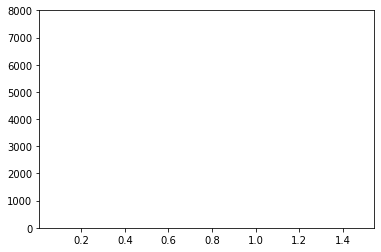

In [21]:
mean = np.loadtxt(os.path.normpath(os.path.join(write_path,'mean_mixed_log.txt')))
std = np.loadtxt(os.path.normpath(os.path.join(write_path,'std_mixed_log.txt')))
hidden1_b_unnorm = (hidden1_b*std)+mean
recon = reconstruct(hidden1_b_unnorm, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)

Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
plt.show()

In [14]:
recon = reconstruct(hidden1_b, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)

C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in power
C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


In [97]:
import h5py 
import tensorflow as tf
hh = h5py.File('ftr_refrmd_10h.hdf5', 'r')
d=hh['ftr_refrmd_10h'][0]
len_data=d.shape
hh.close()
len_data

(771,)

In [24]:
file.close()

In [92]:
dataset

<PrefetchDataset shapes: ((?, 257), (?,)), types: (tf.float32, tf.float32)>